In [ ]:
import csv
import sys
import os 
import re
import matplotlib.pyplot as plt
from collections import Counter

In [112]:
def sam_reading(sam_file_path):
# Ouvrir le fichier SAM
    with open(sam_file_path, "r") as sam_file:
        # Initialiser le lecteur CSV (camma seperated values) avec le délimiteur de tabulation car le fichier SAM est séparé par des tabulations
        sam_reader = csv.reader(sam_file, delimiter='\t')
        
        # Parcourir chaque ligne du fichier SAM
        flags=[] #list
        quals=[]
        maps_score=[]
        coverage={} #dictionnaire
        # Pour chaque ligne de mon fichier SAM 
        for row in sam_reader:
            # Ignorer les lignes d'en-tête qui commencent par '@'
            if row[0].startswith("@"):
                continue
            
            # Accéder aux informations de chaque colonne
            qname = row[0]    # Nom du read
            flag = int(row[1]) # Flag
            flags.append(flag) # rajouter le flag de chaque ligne dans la liste
            rname = row[2]    # Nom de la séquence de référence
            start_pos = int(row[3])  # Position de début de l'alignement
            mapq = int(row[4]) # Qualité de l'alignement
            maps_score.append(mapq)
            cigar = row[5]    # Chaîne CIGAR
            rnext = row[6]    # Référence du read suivant dans le cas des paires
            pnext = int(row[7]) # Position du read suivant dans le cas des paires
            tlen = int(row[8]) # Longueur du fragment pour les paires
            seq = row[9]      # Séquence de l'ADN
            seq_length = len(seq)
            qual = row[10]    # Qualité de chaque base dans la séquence
            quals.append(qual) # rajouter la qual de chaque ligne dans la liste

            # pour la question 3 localisation des reads sur la séquence 

            for pos in range(start_pos, start_pos + seq_length):
                if pos in coverage:
                    coverage[pos] += 1
                else:
                    coverage[pos] = 1

            # Afficher les informations du read
            #print(f"QNAME: {qname}, FLAG: {flag}, RNAME: {rname}, POS: {pos}, CIGAR: {cigar}, SEQ: {seq}")
    return flags, quals, coverage, maps_score


Question 1

In [113]:
# Je définie une fonction nommée flags_to_binary pour convertir le flag en binaire parceque le flag contient les infos en bit 
def flags_to_binary(flag_size, flags):
    # Boucle qui va parcourir de 0 à la taille des flags-1
    for i in range(len(flags)):
        flags[i]=bin(flags[i])
        # Éliminer les 2 premiers caractères du flag (0 et b) & les remplir de 0 sur la gauche -> atteindre la taille souhaitée
        flags[i]=flags[i][2:].zfill(flag_size)
        # Faire retourner une liste de flag transformée en binaire
    return flags
        

In [114]:

# Je définie une fonction nommée number_of_mapped_reads qui prend en paramètre la taille des flags et les flags en binaire
def number_of_mapped_reads (flag_size, binary_flags):
    mapped_reads = []
    flag_size = flag_size - 1
    nbr = 0
    for i in range(len(binary_flags)):
        # Mettre le flag en binaire de la ligne en question (i) dans la variable flag
        flag=binary_flags[i]
        # le bit 2 code pour l'info "read mappé ou pas", donc on soustrait le chiffre 2 de la taille du flag (12-1=11). Si "0" = mappé 
        if (flag[flag_size-2] == "0"):
        # Rajouter 1 pour compter le nombre de read
            nbr = nbr + 1
            mapped_reads.append(i)
    print ("J'ai", nbr, "read mappés")
    return mapped_reads


Question 2

In [115]:
def mapped_sur_brin_complementaire (flag_size, binary_flags):
    flag_size = flag_size - 1
    nbr = 0
    for i in range(len(binary_flags)):
        flag=binary_flags[i]
        if (flag[flag_size-4] == "1"):
            nbr = nbr + 1
    print ("J'ai", nbr, "read mappés sur le brin complémentaire")

In [116]:
def premier_de_la_paire (flag_size, binary_flags):
    flag_size = flag_size - 1
    nbr = 0
    for i in range(len(binary_flags)):
        flag=binary_flags[i]
        # Les 2 conditions doivent être VRAI; la 1ère pour dire si le read est le 1er de la paire & la 2ème pour s'assurer que c une paire
        if ((flag[flag_size-6] == "1") and flag[flag_size-0] == "1"):
            nbr = nbr + 1
    print ("J'ai", nbr, "read qui sont les premiers de la paire")

In [117]:
def second_de_la_paire (flag_size, binary_flags):
    flag_size = flag_size - 1
    nbr = 0
    for i in range(len(binary_flags)):
        flag=binary_flags[i]
        # Les 2 conditions doivent être VRAI; la 1ère pour dire si le read est le 2ème de la paire & la 2ème pour s'assurer que c une paire
        if ((flag[flag_size-7] == "1") and flag[flag_size-0] == "1"):
            nbr = nbr + 1
    print ("J'ai", nbr, "read qui sont les seconds de la paire")


Question 3 qui est la position des reads

In [118]:
def read_positions (coverage):
   
    positions = sorted(coverage.keys())
    coverages = [coverage[pos] for pos in positions]

    #Afficher un graphique de la couverture
    plt.figure(figsize=(10, 5))
    plt.plot(positions, coverages, label="Couverture")
    plt.xlabel("Position sur la séquence de référence")
    plt.ylabel("Nombre de reads (couverture)")
    plt.title("Couverture des reads le long de la séquence de référence")
    plt.legend()
    plt.show()

Question 4

In [ ]:
def mapping_quality (maps_score):
    # La fonction Counter crée un dictionnaire avec chaque valeur de qualité qui est associé au nombre de reads
    mapq_counts = Counter(maps_score)
    
    print(mapq_counts)

    # défintion du seuil à 30

    seuil_mapq = 30
    read_quality_greater_30 = []

    for i in range(len(maps_score)):
        if (maps_score[i] > 30):
            read_quality_greater_30.append(i)

    return read_quality_greater_30


Filtrage des reads avec les reads qui sont compètement mappé et qui ont un score 

In [120]:
def filtred_reads (mapped_reads, read_quality_greater_30, sam_file_path):

    filtred_sam_file = "filtred_reads.sam"
    filtered_indices = set(mapped_reads).intersection(read_quality_greater_30)

    with open(sam_file_path, "r") as sam_file, open(filtred_sam_file, "w", newline='') as output_file:
        # Initialiser le lecteur CSV (camma seperated values) avec le délimiteur de tabulation car le fichier SAM est séparé par des tabulations
        sam_reader = csv.reader(sam_file, delimiter='\t')
        output_writer = csv.writer(output_file, delimiter='\t')

        for index, row in enumerate(sam_reader):
        # Conserver les lignes d'en-tête (commencent par '@')
            if row[0].startswith("@"):
                output_writer.writerow(row)
                continue

            # Si l'index du read est dans l'intersection des deux listes, on l'ajoute au fichier de sortie
            if index in filtered_indices:
                output_writer.writerow(row)

J'ai 350015 read mappés
J'ai 175008 read mappés sur le brin complémentaire
J'ai 175665 read qui sont les premiers de la paire
J'ai 175665 read qui sont les seconds de la paire


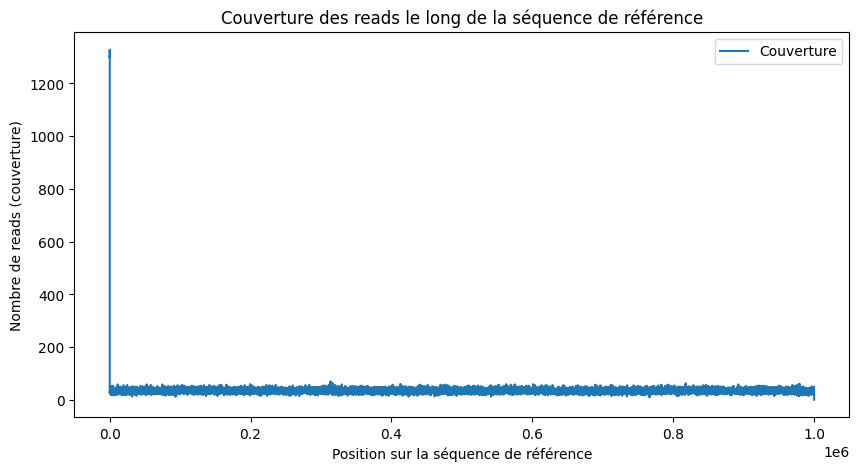

Counter({60: 301109, 0: 34800, 40: 2893, 27: 2650, 50: 2389, 25: 2285, 48: 932, 24: 670, 55: 494, 47: 456, 49: 405, 57: 380, 45: 264, 39: 178, 43: 137, 52: 132, 33: 100, 54: 97, 42: 76, 37: 74, 9: 74, 15: 72, 13: 72, 3: 70, 19: 62, 31: 60, 7: 55, 46: 54, 1: 54, 21: 51, 51: 30, 44: 28, 30: 23, 53: 21, 36: 20, 18: 16, 6: 15, 12: 8, 38: 6, 41: 4, 23: 4, 59: 2, 11: 2, 34: 2, 10: 1, 26: 1, 28: 1, 35: 1})


In [122]:
sam_file_path = "/Users/aichaeljai/Desktop/projet_mapping/mapping.sam"
flag_size = 12
# J'appelle la fonction sam_reading qui prend en paramètre le chemin et qui me retourne les flags et les quals
flags, quals, coverage, maps_score = sam_reading(sam_file_path)
binary_flags = flags_to_binary(flag_size ,flags)
mapped_reads = number_of_mapped_reads(flag_size, binary_flags)
mapped_sur_brin_complementaire(flag_size, binary_flags)
premier_de_la_paire(flag_size, binary_flags)
second_de_la_paire(flag_size, binary_flags)
read_positions(coverage)
read_quality_greater_30 = mapping_quality(maps_score)
filtred_reads(mapped_reads, read_quality_greater_30, sam_file_path)


# Enregistrer les qualitès dans un fichier texte avec une en-tête et 'w' pour modifier le fichier
with open("quals_output.txt", "w") as output_file:
    # Écrire l'en-tête en sautant une ligne avec \n
    output_file.write("Les qualitès\n")
    
    # Écrire chaque flag dans une nouvelle ligne
    for qual in quals:
        output_file.write(f"{qual}\n")

En observant le graphique de couverture, on peut voir les caractéristiques suivantes :

Pic initial élevé : Il y a un pic très marqué au début de la séquence (position proche de 0) avec une couverture supérieure à 1200. Cela signifie qu'il y a une forte accumulation de reads alignés au tout début de la séquence de référence. Ce type de pic peut être dû à plusieurs raisons, comme un biais dans la préparation de la bibliothèque ou une région répétitive dans le génome qui attire de nombreux alignements.
Couverture faible et stable après le pic : Après ce pic initial, la couverture reste relativement basse et constante le long de la séquence. Cette région semble bien couverte mais sans accumulation importante. Cela indique que l'alignement des reads est plus ou moins uniforme, sauf pour le pic au début.
Absence de grandes variations : Hormis le pic initial, la couverture est assez homogène. Cela suggère que la couverture des reads est régulière, avec des petites fluctuations, mais sans zones de forte ou faible couverture.
Interprétation
Alignement non homogène : Ce graphique indique que l'alignement n'est pas complètement homogène, en raison du pic au début de la séquence. Cependant, après ce pic, l'alignement semble assez régulier.
Possibilité de biais de séquençage : Le pic au début peut résulter d'un biais dans le séquençage ou d'une région répétitive dans le génome qui attire les alignements.
Utilisation du pic pour investigation : Vous pourriez enquêter sur cette région pour vérifier s'il y a des séquences répétées ou des artefacts de séquençage.
Si ce pic n'est pas souhaité (c'est-à-dire qu'il représente du bruit ou un biais technique), vous pourriez le filtrer ou l'ignorer dans vos analyses pour obtenir une couverture plus représentative du reste de la séquence.






